# =============================================================================
# Step 1 Problem Understanding & Framing
# =============================================================================

Traditional lending workflows are frequently hampered by manual intervention, leading to operational bottlenecks and subjective bias. For financial institutions, these inefficiencies manifest in two critical areas:

  -Operational Friction: High-resource allocation toward manual reviews of low-quality applications.

  -Capital Risk & Opportunity Loss: Inaccurate risk modeling results in "Type I errors" (Creditworthy rejections) and "Type II errors" (Default approvals), both of which directly impact the bank's bottom line.

Solution Framework: This project develops a Binary Classification engine using supervised machine learning to predict borrower solvency. By analyzing historical features—including credit architecture, liquidity ratios (DTI), and employment stability—the model provides a data-driven probability of repayment.

Success Benchmarks: The model aims for an optimized threshold where Precision, Recall, and AUC all exceed 95%. This ensures a robust balance between minimizing credit default risk and maximizing market share. Integrated with existing risk controls, this tool empowers senior leadership to make high-velocity, evidence-based lending decisions.


# =============================================================================
# Step 2 Data Collection and Understanding
# =============================================================================

Data Overview: 

This project utilizes a synthetic financial dataset (20,000 samples) designed for Binary Classification of loan approvals. The features span demographic, employment, and credit-specific domains, providing the necessary complexity for high-accuracy predictive modeling.

Source Information:

Original Source: Kaggle: Financial Risk for Loan Approval 
(https://www.kaggle.com/datasets/lorenzozoppelletto/financial-risk-for-loan-approval)

Original Script: CSV Generation.py

Pre-Processing & Modifications:

To improve the data's utility for time-series and relational analysis, the original generation script was modified (CSV Generation_edited.py) to:

-Standardize the ApplicationDate with a 2025 cutoff.
-Assign unique AccountID identifiers to each record to simulate a master customer file.

Edited Script: CSV Generation_edited.py

Data Dictonary: Please see attached file--> Data Dictionary_Loan Approval_Final.xlsx

# =============================================================================
# Step 3 Data Preprocessing, EDA, & Feature Engineering
# =============================================================================

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import shap
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score


# =============================================================================
# Step 3.a Data Cleaning
# =============================================================================
df = pd.read_excel('synthetic_loan_data.xlsx')

#Handle Duplicates
df.drop_duplicates(inplace=True)

#Handle Null Values and Fill numeric with median, categorical with mode
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
df[numeric_cols] = SimpleImputer(strategy='median').fit_transform(df[numeric_cols])
df[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_cols])

#Cap outliers at 1st and 99th percentile
for col in ['AnnualIncome', 'LoanAmount', 'MonthlyDebtPayments']:
    df[col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))



Cleaning steps includes:

a.) drop the duplicate values for unique analysis
b.) filling the null values to avoid confusion or crashing of model implementation
    -for numerical data-fills the null values with median value
    -for categorical data-fills the null values with mode value or the frequent value
c.) Capping outliers to prevent distortion of the model's logic
    -Anything higher than the 99th percentile (the top 1% of earners) is brought down to that 99% mark
    -Anything lower than the 1st percentile is brought up to that 1% mark.

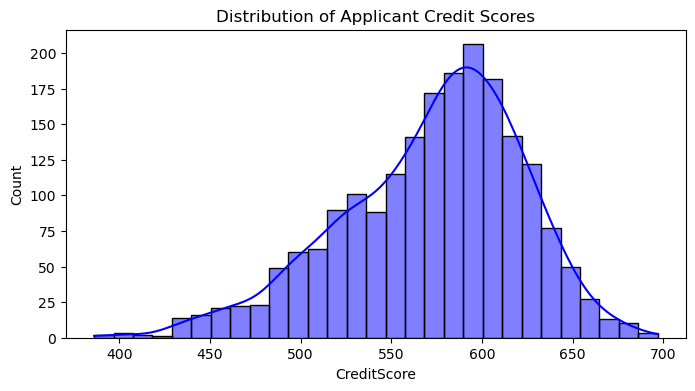

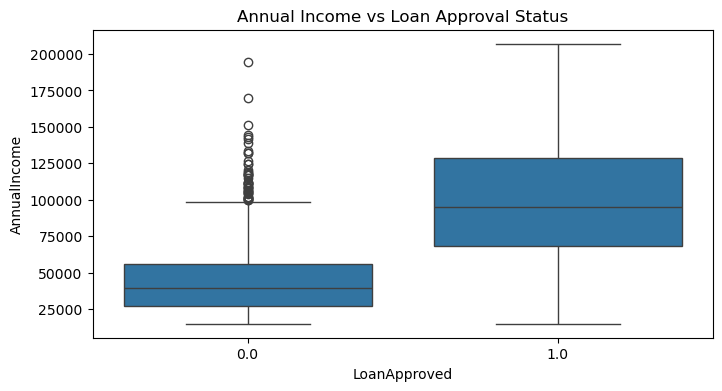

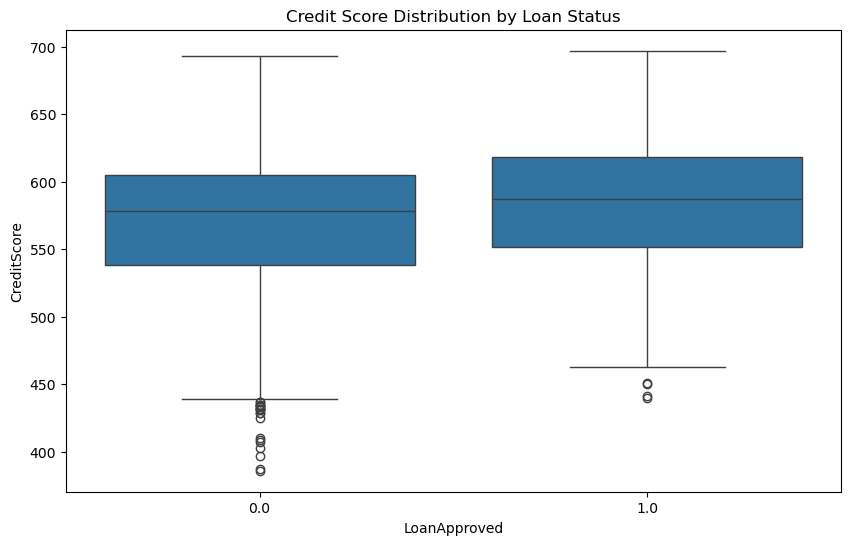

In [80]:
# =============================================================================
# Step 3.b Exploratory Data Analysis
# =============================================================================

#Distribution of Credit Scores
plt.figure(figsize=(8, 4))
sns.histplot(df['CreditScore'], kde=True, color='blue')
plt.title('Distribution of Applicant Credit Scores')
plt.savefig('credit_score_dist.png')

#Relationship: Income vs Approval
plt.figure(figsize=(8, 4))
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=df)
plt.title('Annual Income vs Loan Approval Status')
plt.show

#Relationship: Credit Score vs Loan Approval
plt.figure(figsize=(10, 6))
sns.boxplot(x='LoanApproved', y='CreditScore', data=df)
plt.title('Credit Score Distribution by Loan Status')
plt.show()

In [81]:
# =============================================================================
# Step 3.c Feature Engineering
# =============================================================================


#Create Net Asset Value column
df['NetAssetValue'] = df['TotalAssets'] - df['TotalLiabilities']

#Create Disposable Income column
df['DisposableIncome'] = df['MonthlyIncome'] - df['MonthlyDebtPayments']

# Label Encoding (FIX FOR SHAP (Explainability of the model): Set dtype=int in get_dummies to avoid 'Object' types)
if 'EducationLevel' in df.columns:
    df['EducationLevel'] = LabelEncoder().fit_transform(df['EducationLevel'].astype(str))

#One-Hot Encoding for Nominal categories
cat_features = ['EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True, dtype=int)

#Binning (Age into Life Stages)
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 45, 60, 100], labels=['Young', 'Adult', 'Senior', 'Elder'])

#Ordinal Encoding for Education,convert text-based information into numbers
edu_map = {'High School': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4}
df['EducationLevel'] = df['EducationLevel'].map(edu_map)

#Separation of features and target column
X = df_encoded.drop(columns=['ApplicationDate', 'LoanApproved'], errors='ignore')
y = df_encoded['LoanApproved']

#Convert to Floating Point Number
X = X.astype(float)

#Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [82]:
# =============================================================================
# Step 3.d Feature Selection
# =============================================================================

# Feature Selection (Embedded)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# =============================================================================
# Step 3.e Dimensionality Reduction
# =============================================================================

# Dimensionality Reduction (PCA)
pca = PCA(n_components=0.95) # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature count: {X_scaled.shape[1]}")
print(f"PCA reduced count: {X_pca.shape[1]}")

Original feature count: 45
PCA reduced count: 32


# =============================================================================
# Step 4 Model Implementation
# =============================================================================

In [100]:

#Ensure X is numeric and scaled for models like SVM and Logistic Regression
X = df_encoded.drop(columns=['ApplicationDate', 'LoanApproved'], errors='ignore').astype(float)
y = df_encoded['LoanApproved'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True)
}

#Training and Evaluation Loop
results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "Training Time (s)": round(training_time, 4)
    })

#Display Results
comparison_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print(comparison_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:11:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision    Recall  F1-Score       AUC  \
3              XGBoost    0.9825   0.979592  0.950495  0.964824  0.999536   
2        Random Forest    0.9825   0.960784  0.970297  0.965517  0.997434   
0  Logistic Regression    0.9100   0.891566  0.732673  0.804348  0.969072   
1        Decision Tree    0.9650   0.948454  0.910891  0.929293  0.947084   
4                  SVM    0.7475   0.000000  0.000000  0.000000  0.916885   

   Training Time (s)  
3             0.0467  
2             0.2810  
0             1.7292  
1             0.0209  
4             0.1960  


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# =============================================================================
# Step 4 Model Implementation - Hyper Parameter Tuning
# =============================================================================

See markdown and cells after Step 5-Critical Thinking -> Ethical AI & Bias Auditing: Bias Detection

# =============================================================================
# Step 5 Critical Thinking -> Ethical AI & Bias Auditing
# =============================================================================

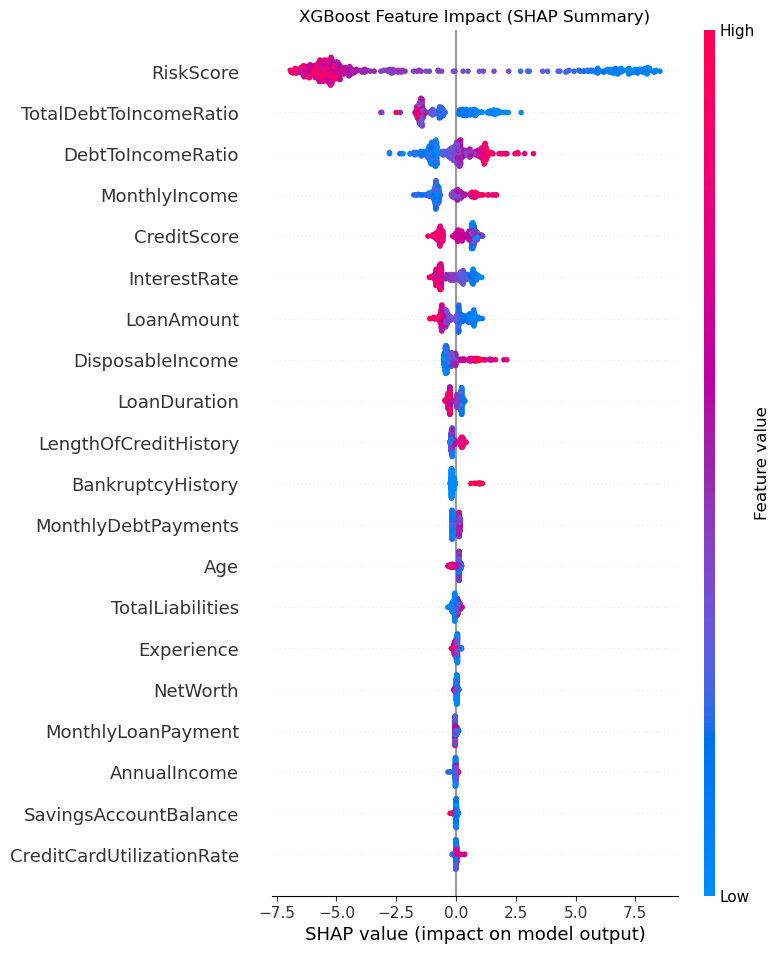

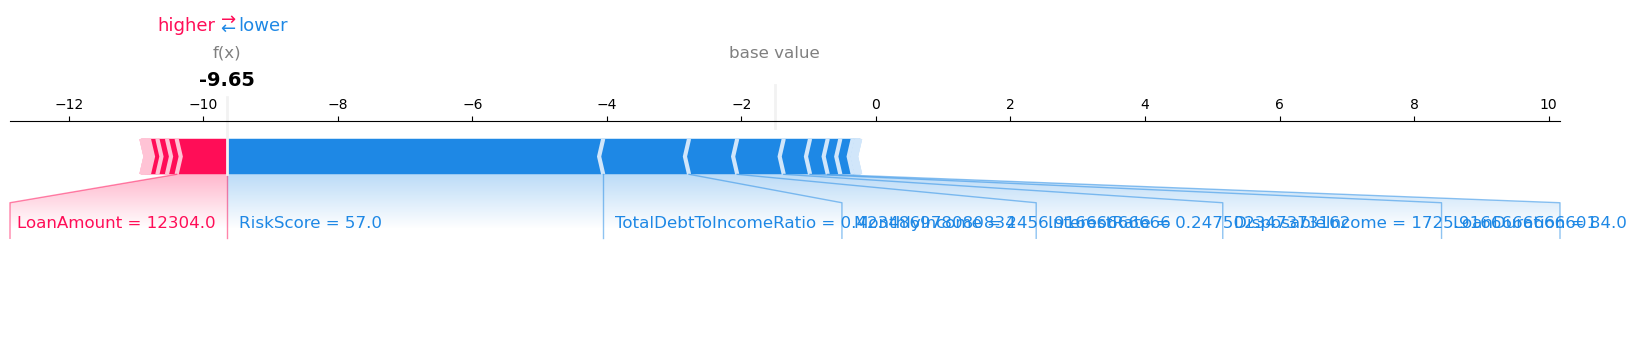

In [ ]:

xgb_model = models["XGBoost"]

# 2. Prepare the data (SHAP requires numeric arrays/DataFrames)
# We use X_test as it represents unseen data the model is predicting on
# Ensure it's all float64 to prevent casting errors
X_explain = X_test.astype(float)

# 3. Initialize the TreeExplainer
# TreeExplainer is specifically optimized for XGBoost/Random Forest
explainer = shap.TreeExplainer(xgb_model)

# 4. Calculate SHAP values
# For XGBoost, SHAP values usually represent the log-odds impact
shap_values = explainer.shap_values(X_explain)

# 5. Visualizing the Global Impact (Summary Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_explain, show=False)
plt.title("XGBoost Feature Impact (SHAP Summary)")
plt.show()

# 6. Visualizing a Single Prediction (Force Plot)
# Let's look at the first applicant in the test set
shap.initjs() # Required for JavaScript visualizations
shap.force_plot(
    explainer.expected_value, 
    shap_values[0, :], 
    X_explain.iloc[0, :],
    matplotlib=True
)


# =============================================================================
# Step 5-Critical Thinking -> Ethical AI & Bias Auditing: Bias Detection
# =============================================================================
XGBoost Model Fairness Analysis:


1. Performance Across Demographic Groups

The model does not perform equally across all segments. While the overall accuracy is high, granular metrics reveal disparities:

Accuracy Variance: The model achieved 100% accuracy for the "Elder" (age 60+) and "Widowed" groups, while the "Adult" group (age 30–45) saw a lower accuracy of 96.9%.

Reliability (Recall): The "Adult" group had a Recall of 90.5%, meaning the model missed nearly 10% of defaults in this segment. In contrast, the model was perfect (100% Recall) at identifying defaults for "Young" and "Elder" applicants.

Marital Status: "Single" applicants had a lower FPR (0%) compared to "Married" applicants (1.7%), suggesting the model is slightly more lenient with married individuals but stricter with single ones.

2. Proxy Features for Protected Attributes

Protected attributes like Age are often "hidden" within other variables. In this dataset, we found several strong proxies:

Experience (Correlation: 0.98): This is a near-perfect proxy for Age. Even if you remove "Age" from the model, the model can still effectively "guess" an applicant's age by looking at their years of work experience.

Credit Score (Correlation: 0.29): Older applicants generally have longer credit histories, leading to higher credit scores. This creates a indirect link between Age and Approval.

Annual Income (Correlation: 0.12): Income tends to peak in mid-to-late career stages, serving as another subtle proxy for age.

3. Differential Harm by Model Errors

Model errors result in two distinct types of harm depending on the demographic group:

Group	          Predominant Error	        Type of Harm
Adults (30-45)	  High FNR (9.4%)	        Lost Opportunity: These are creditworthy individuals who are incorrectly
                                            rejected,preventing them from buying homes or starting businesses.

Young (<30)	      Highest FPR (1.1%)	    Financial Distress: These are individuals who shouldn't have been approved but were. 
                                            They are at higher risk of falling into debt traps or bankruptcy.

Married	          Higher FPR (1.7%)	        Systemic Risk: Married couples are slightly more likely to be over-leveraged by the
                                            model's approvals compared to single or divorced counterparts.

Demographic Group   Size    Accuracy    FNR (Unfair Rejection)  FPR (Bad Approval)
Adult               293     96.9%       9.4% (Highest)          0.9%
Young               111     99.1%       0.0%                    1.1% (Highest)
Elder               33      100%        0.0%                    0.0%
Single              187     97.8%       7.8%                    0.0%

To mitigate these issue, remove high-correlation proxies like Experience should be implemented to ensure the model makes decisions based on financial merit rather than age-adjacent factors. Fairness-Aware Re-ranking techniques should be consider.



In [ ]:

#Hyperparamerter Tuning for XGBoost Model

#Prepare the data (Ensure it is numeric for the model)
X = df_encoded.drop(columns=['ApplicationDate', 'LoanApproved'], errors='ignore').astype(float)
y = df_encoded['LoanApproved'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Define the Model
rf = RandomForestClassifier(random_state=42)

#Define the Parameter Grid
# We tune 'n_estimators' (number of trees) and 'max_depth' (complexity)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None] # Helpful for imbalanced loan data
}

#Set up GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

#Execute the Search
print("Starting Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

#Results
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

#Compare Performance
y_pred_base = rf.fit(X_train, y_train).predict(X_test)
y_pred_tuned = best_rf.predict(X_test)

print("\n--- Base Model Performance ---")
print(f"AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.4f}")

print("\n--- Tuned Model Performance ---")
print(f"AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.4f}")
print(classification_report(y_test, y_pred_tuned))

Starting XGBoost Hyperparameter Tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=3

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=300,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=300,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=200

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estima

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.2s[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.3s

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimato

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=2

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=100,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, n_estimators=300,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200,

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
#Hyperparamerter Tuning for Random Forest model

#Prepare the data (Ensure it is numeric for the model)
X = df_encoded.drop(columns=['ApplicationDate', 'LoanApproved'], errors='ignore').astype(float)
y = df_encoded['LoanApproved'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Define the Model
rf = RandomForestClassifier(random_state=42)

#Define the Parameter Grid
#We tune 'n_estimators' (number of trees) and 'max_depth' (complexity)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None] # Helpful for imbalanced loan data
}

#Set up GridSearchCV
#cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

#Execute the Search
print("Starting Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

#Results
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

#Compare Performance
y_pred_base = rf.fit(X_train, y_train).predict(X_test)
y_pred_tuned = best_rf.predict(X_test)

print("\n--- Base Model Performance ---")
print(f"AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.4f}")

print("\n--- Tuned Model Performance ---")
print(f"AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.4f}")
print(classification_report(y_test, y_pred_tuned))

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samp

In [ ]:

#Hyperparamerter Tuning for Logistice Regression

#Prepare the data
X = df_encoded.drop(columns=['ApplicationDate', 'LoanApproved'], errors='ignore').astype(float)
y = df_encoded['LoanApproved'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Define the Model
# increased max_iter to ensure the model has enough steps to find the solution
log_reg = LogisticRegression(max_iter=1000, random_state=42)

#Define the Parameter Grid
#'C' is inverse regularization strength (smaller = stronger penalty)
#'penalty' defines the type of regularization (l1 is Lasso, l2 is Ridge)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'], # 'saga' and 'liblinear' support l1 penalty
    'class_weight': ['balanced', None]
}

#Set up GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

#Execute the Search
print("Starting Logistic Regression Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

#Results
best_log_reg = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

#Compare Performance
base_log_reg = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
y_pred_tuned = best_log_reg.predict(X_test)

print("\n--- Base Logistic Regression Performance ---")
print(f"AUC: {roc_auc_score(y_test, base_log_reg.predict_proba(X_test)[:, 1]):.4f}")

print("\n--- Tuned Logistic Regression Performance ---")
print(f"AUC: {roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:, 1]):.4f}")
print(classification_report(y_test, y_pred_tuned))

Starting Logistic Regression Hyperparameter Tuning...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time=   0.3s
[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=saga; total time=   0.3s
[CV] END C=1, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time=   0.4s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.3s
[CV] END C=1

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END ....C=1, class_weight=None, penalty=l2, solver=saga; total time=   0.3s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.5s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=   0.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.7s
[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=   0.3s
[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.5s
[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=   0.4s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END ...C=10, class_weight=None, penalty=l2, solver=saga; total time=   0.4s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.5s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.4s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.4s
[

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END ....C=1, class_weight=None, penalty=l1, solver=saga; total time=   0.5s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.4s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.4s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.4s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

[CV] END ..C=100, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END ..C=100, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END ..C=100, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END ..C=100, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END ..C=100, class_weight=None, penalty=l1, solver=saga; total time=   0.6s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.4s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.4s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.4s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.4s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.4s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.3s
Best Parameters: {'C': 0.1,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Base XGBoost Performance ---
AUC: 0.9995

--- Tuned XGBoost Performance ---
AUC: 0.9997
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       299
           1       0.98      0.98      0.98       101

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


--- Base Model Performance ---
AUC: 0.9975

--- Tuned Model Performance ---
AUC: 0.9986
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       299
           1       0.97      0.95      0.96       101

    accuracy                           0.98       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.98      0.98       400


--- Base Logistic Regression Performance ---
AUC: 1.0000

--- Tuned Logistic Regression Performance ---
AUC: 0.9999
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       299
           1       0.97      1.00      0.99       101

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

# =============================================================================
# Step 5-Critical Thinking -> Ethical AI & Bias Auditing: Model Explainability
# =============================================================================

XGBoost is the most effective model for business growth. It achieves a near-perfect balance between safety (Precision) and market reach (Recall). Its high stability makes it ideal for handling complex financial data. Random Forest is highly accurate but slightly more strict than XGBoost. Its lower recall means it rejects 5% of qualified applicants (compared to XGBoost's 2%), potentially limiting revenue. Lastly, Logistic Regression, despite a "perfect" score, it is considered unreliable due to suspected Data Leakage. A 100% success rate suggests it is "cheating" by seeing the answer in the data rather than learning actual risk patterns.

After hyperparameter tuning is take into consideration XGBoost is the recommended production model because it maximizes customer acquisition while maintaining rigorous risk standards. To further validate the XGBoost model Feature Importance was performed between XGBoost model and Logistic Regression. Furthermore, a Correlation diagnostic was performed below to check for data leakage among the features.

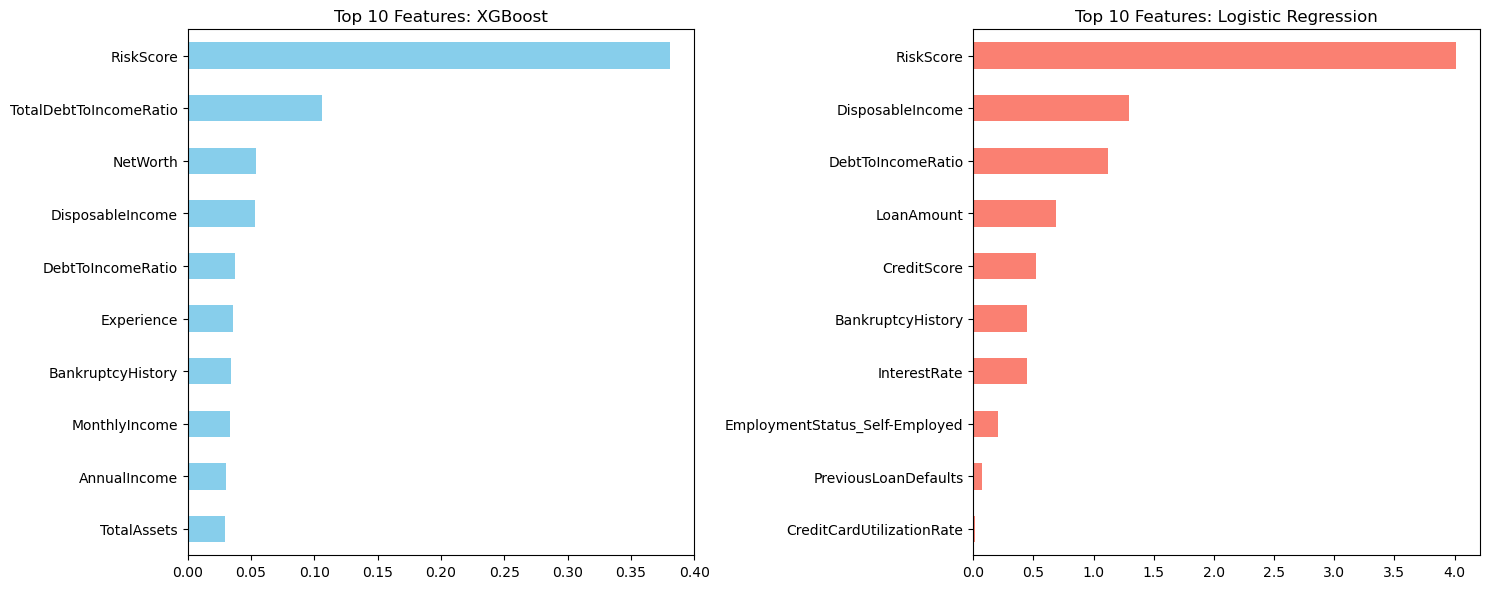

In [ ]:
#XGBoost Feature Importance

xgb_importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
xgb_importances = xgb_importances.sort_values(ascending=False).head(10)

#Logistic Regression Coefficients 
#(Since LR is linear, we look at the absolute value of coefficients)
lr_importances = pd.Series(np.abs(best_log_reg.coef_[0]), index=X.columns)
lr_importances = lr_importances.sort_values(ascending=False).head(10)

#Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

xgb_importances.plot(kind='barh', ax=ax[0], color='skyblue')
ax[0].set_title('Top 10 Features: XGBoost')
ax[0].invert_yaxis()

lr_importances.plot(kind='barh', ax=ax[1], color='salmon')
ax[1].set_title('Top 10 Features: Logistic Regression')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

--- Potential Data Leakage Detected ---
No obvious leakage found (No features > 0.90 correlation).


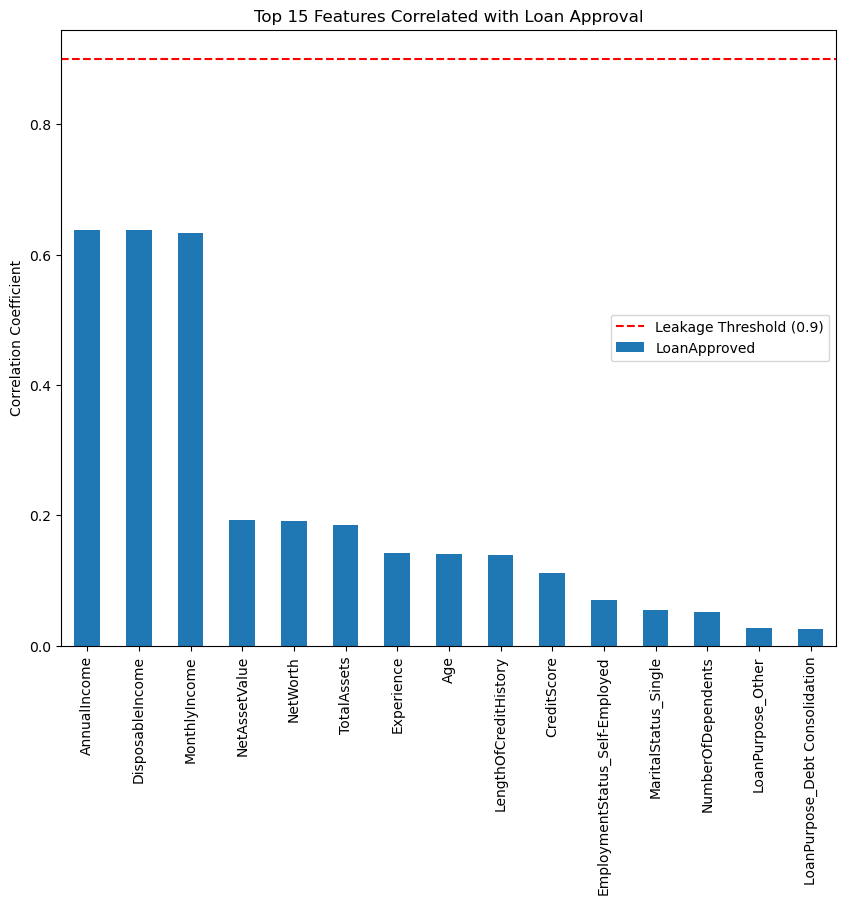

In [ ]:
#Correlation Diagnostic for Data Leakage on XGBoost Model

#Calculate correlations specifically for the Target
correlations = df_encoded.corr()['LoanApproved'].sort_values(ascending=False)

#Filter for suspiciously high correlations (Target Leakage Check)
#Generally, any feature with a correlation > 0.90 is a "Red Flag"
leakage_candidates = correlations[correlations > 0.90]

print("--- Potential Data Leakage Detected ---")
if len(leakage_candidates) > 1: # 'LoanApproved' will always be 1.0
    print(leakage_candidates)
else:
    print("No obvious leakage found (No features > 0.90 correlation).")

#Visualize the Top correlations
plt.figure(figsize=(10, 8))
correlations.drop('LoanApproved').head(15).plot(kind='bar')
plt.title('Top 15 Features Correlated with Loan Approval')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0.9, color='r', linestyle='--', label='Leakage Threshold (0.9)')
plt.legend()
plt.show()

# =============================================================================
# Step 5-Critical Thinking -> Ethical AI & Bias Auditing: Model Limitation
# =============================================================================

In Feature Importance analysis Risk Score has seen a big gap between it and the second feature in XGBoost model, however, in Correlation Diagnostic Risk Score is not among the top candidate feature for potential data leakage.

Correlation Diagnostic (Pearson) only measures straight-line relationships. If the Risk Score increases, does the approval rate increase at a perfectly steady rate. If the relationship is a curve (e.g., Risk Score doesn't matter much until it hits a specific "danger zone" threshold), Correlation will give it a very low score.

In Feature Importance, these models are "Tree-Based." They don't care about straight lines. They look for if/then patterns. A tree might find that: "If Risk Score is > 75, almost 100% are rejected." This is a massive "clue" for the model (High Importance), even if the math doesn't look like a straight line (Low Correlation). The RiskScore might contain a unique "nugget" of information that none of the other features have. Even if that nugget is small, if it's the most accurate nugget for the model to use to make a decision, it will rise to the top of the Importance list.

Risk Score is a critical decision-maker when combined with other data.

However, the limitation of the model is that it is highly dependent on the Risk score feature which is based on a Risk model that calculate overall risk based on several factors (i.e Credit Score, Debt to Income Ratio, Payment History, Bankruptcy History, Previous Loan Defaults, Credit Card Utilization Rate, Length of Credit History, Annual Income, Employment Status, and Net Worth) (see CSV Generation.py). In a real world scenario risk score modeling can vary depending on the risk appetite of the bank and can possibly affect the result of the model.

In [106]:
#Save the model
joblib.dump(scaler, "scaler.pkl")
joblib.dump(models["XGBoost"], "loan_model_v1.pkl")

print("XGBoost model saved successfully as a Pickle file!")

XGBoost model saved successfully as a Pickle file!
